=== SETUP AND IMPORTS ===

In [1]:
# Ensure the latest version of the code is used by re-cloning the repository
!rm -rf Deep_Learning-Based_Signature_Forgery_Detection_for_Personal_Identity_Authentication
!git clone https://github.com/trongjhuongwr/Deep_Learning-Based_Signature_Forgery_Detection_for_Personal_Identity_Authentication.git
%cd Deep_Learning-Based_Signature_Forgery_Detection_for_Personal_Identity_Authentication

Cloning into 'Deep_Learning-Based_Signature_Forgery_Detection_for_Personal_Identity_Authentication'...
remote: Enumerating objects: 3428, done.
remote: Counting objects: 100% (131/131), done.
remote: Compressing objects: 100% (97/97), done.
remote: Total 3428 (delta 61), reused 81 (delta 34), pack-reused 3297 (from 3)
Receiving objects: 100% (3428/3428), 248.44 MiB | 19.68 MiB/s, done.
Resolving deltas: 100% (366/366), done.
/kaggle/working/Deep_Learning-Based_Signature_Forgery_Detection_for_Personal_Identity_Authentication


In [2]:
import torch
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms, models
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import numpy as np
import random
import os
import json
import sys
import shutil

# Project-specific modules
from dataloader.tSSN_trainloader import SignaturePretrainDataset, get_pretraining_transforms
from models.Triplet_Siamese_Similarity_Network import tSSN
from losses.triplet_loss import TripletLoss

In [3]:
# HYPERPARAMETER CONFIGURATION
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Optimized for ResNet34 & Robustness
INPUT_SHAPE = (224, 224) 
BATCH_SIZE = 32
EPOCHS = 30
LEARNING_RATE = 1e-4
MARGIN = 2.0

# Initialize Data Augmentation Pipeline
# This calls the updated function from your GitHub repo
train_transform = get_pretraining_transforms(input_shape=INPUT_SHAPE)

print(f" > Computation Device: {DEVICE}")
print(f" > Input Shape: {INPUT_SHAPE}")
print(f" > Margin: {MARGIN}")

def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    print(f"Random seed set to: {seed}")

SEED = 42
seed_everything(SEED)

 > Computation Device: cuda
 > Input Shape: (224, 224)
 > Margin: 2.0
Random seed set to: 42


In [4]:
# DATA PREPARATION STRATEGY
working_dir = '/kaggle/working'
genuine_dir = os.path.join(working_dir, 'all_genuine')
forged_dir = os.path.join(working_dir, 'all_forged')

if os.path.exists(genuine_dir):
    shutil.rmtree(genuine_dir)
if os.path.exists(forged_dir):
    shutil.rmtree(forged_dir)

# Create clean directories
os.makedirs(genuine_dir, exist_ok=True)
os.makedirs(forged_dir, exist_ok=True)

print("Status: Consolidating BHSig dataset (Hindi + Bengali) into a unified structure...")

# Symbolic links are used to aggregate Hindi and Bengali datasets without data duplication.
!ln -sf /kaggle/input/bhsig260-hindi-bengali/BHSig160_Hindi/Genuine/* /kaggle/working/all_genuine/
!ln -sf /kaggle/input/bhsig260-hindi-bengali/BHSig100_Bengali/Genuine/* /kaggle/working/all_genuine/
!ln -sf /kaggle/input/bhsig260-hindi-bengali/BHSig160_Hindi/Forged/* /kaggle/working/all_forged/
!ln -sf /kaggle/input/bhsig260-hindi-bengali/BHSig100_Bengali/Forged/* /kaggle/working/all_forged/

print("Status: Data consolidation complete.")

# Execute the data restructuring script.
# Objective: Segregate the dataset into disjoint 'Background' (Pre-training) and 'Evaluation' (Meta-learning) sets.
# Configuration: 150 users for Pre-training (Background), 110 users for Meta-learning (Evaluation).
!python scripts/restructure_bhsig.py \
    --base_dir /kaggle/input/bhsig260-hindi-bengali \
    --output_dir /kaggle/working/splits \
    --pretrain_users 150

# Load the identified background users to restrict the pre-training scope.
background_users_path = '/kaggle/working/splits/bhsig_background_users.json'
try:
    with open(background_users_path, 'r') as f:
        background_users = json.load(f)
    print(f"Success: Loaded {len(background_users)} users for the Pre-training phase (Background Set).")
except FileNotFoundError:
    print("Error: Background users file not found. Ensure the restructuring script executed correctly.")

Status: Consolidating BHSig dataset (Hindi + Bengali) into a unified structure...
Status: Data consolidation complete.
[Info] Scanning data structure at: /kaggle/input/bhsig260-hindi-bengali
[Info] Found 14040 image files. Parsing metadata...
[Info] Successfully validated 260 users with complete data.
[Info] Split Statistics:
   - Background Users (Pre-training): 150
   - Evaluation Users (Meta-learning): 110
[Success] Saved pre-training split to: /kaggle/working/splits/bhsig_background_users.json
   > Generated Fold 0: 88 Train / 22 Val users.
   > Generated Fold 1: 88 Train / 22 Val users.
   > Generated Fold 2: 88 Train / 22 Val users.
   > Generated Fold 3: 88 Train / 22 Val users.
   > Generated Fold 4: 88 Train / 22 Val users.
Success: Loaded 150 users for the Pre-training phase (Background Set).


=== DATASET AND DATALOADER INITIALIZATION ===

In [5]:
# Initialize the Dataset using the consolidated directories
train_dataset = SignaturePretrainDataset(
    org_dir=genuine_dir,
    forg_dir=forged_dir,
    transform=train_transform,
    user_list=background_users
)

# Initialize DataLoader
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,           # Shuffle is CRITICAL for SGD
    num_workers=4,          # Parallel data loading
    pin_memory=True,        # Faster transfer to GPU
    drop_last=True          # Avoid incomplete batches causing issues
)

print(f" > Dataset Prepared.")
print(f" > Total Training Triplets available per epoch: {len(train_dataset)}")
print(f" > Batch Size: {BATCH_SIZE}")

 > Dataset Prepared.
 > Total Training Triplets available per epoch: 3600
 > Batch Size: 32


=== MODEL ARCHITECTURE AND LOSS FUNCTION ===

In [6]:
# 1. Initialize Model
model = tSSN(backbone_name='resnet34', output_dim=512, pretrained=True).to(DEVICE)

# 2. Loss and Optimizer
criterion = TripletLoss(margin=MARGIN)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=3, verbose=True
)

# 3. Training Loop
history = {'loss': []}
CHECKPOINT_DIR = './checkpoints'
os.makedirs(CHECKPOINT_DIR, exist_ok=True)

print(f"Starting Training for {EPOCHS} epochs...")

for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0
    
    # REGENERATE TRIPLETS: Critical for Online Hard Mining
    # This reshuffles pairs to find new hard negatives every epoch
    train_dataset.on_epoch_end()
    
    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}", leave=False)
    
    for batch_idx, (anchor, positive, negative, _) in enumerate(pbar):
        anchor, positive, negative = anchor.to(DEVICE), positive.to(DEVICE), negative.to(DEVICE)
        
        optimizer.zero_grad()
        
        # Forward pass
        anchor_emb, pos_emb, neg_emb = model(anchor, positive, negative)
        
        # Compute Loss
        loss = criterion(anchor_emb, pos_emb, neg_emb)
        
        # Backward pass
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        pbar.set_postfix({'loss': loss.item()})
        
    avg_loss = running_loss / len(train_loader)
    history['loss'].append(avg_loss)
    
    # Update Scheduler
    scheduler.step(avg_loss)
    
    print(f"Epoch [{epoch+1}/{EPOCHS}] | Triplet Loss: {avg_loss:.4f} | LR: {optimizer.param_groups[0]['lr']:.2e}")
    
    # Save Checkpoint every 5 epochs
    if (epoch + 1) % 5 == 0:
        torch.save(model.state_dict(), os.path.join(CHECKPOINT_DIR, f"tSSN_pretrain_epoch_{epoch+1}.pth"))

# Save Final Feature Extractor Weights
final_weights_path = "background_pretrain.pth"
torch.save(model.feature_extractor.state_dict(), final_weights_path)
print(f"\nTraining Complete. Final weights saved to: {final_weights_path}")

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 245MB/s]
/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Starting Training for 30 epochs...


Epoch 1/30:   0%|          | 0/112 [00:00<?, ?it/s]

Epoch [1/30] | Triplet Loss: 1.8971 | LR: 1.00e-04


Epoch 2/30:   0%|          | 0/112 [00:00<?, ?it/s]

Epoch [2/30] | Triplet Loss: 1.9361 | LR: 1.00e-04


Epoch 3/30:   0%|          | 0/112 [00:00<?, ?it/s]

Epoch [3/30] | Triplet Loss: 1.6481 | LR: 1.00e-04


Epoch 4/30:   0%|          | 0/112 [00:00<?, ?it/s]

Epoch [4/30] | Triplet Loss: 1.3865 | LR: 1.00e-04


Epoch 5/30:   0%|          | 0/112 [00:00<?, ?it/s]

Epoch [5/30] | Triplet Loss: 1.7194 | LR: 1.00e-04


Epoch 6/30:   0%|          | 0/112 [00:00<?, ?it/s]

Epoch [6/30] | Triplet Loss: 1.2219 | LR: 1.00e-04


Epoch 7/30:   0%|          | 0/112 [00:00<?, ?it/s]

Epoch [7/30] | Triplet Loss: 1.4152 | LR: 1.00e-04


Epoch 8/30:   0%|          | 0/112 [00:00<?, ?it/s]

Epoch [8/30] | Triplet Loss: 0.9626 | LR: 1.00e-04


Epoch 9/30:   0%|          | 0/112 [00:00<?, ?it/s]

Epoch [9/30] | Triplet Loss: 0.7907 | LR: 1.00e-04


Epoch 10/30:   0%|          | 0/112 [00:00<?, ?it/s]

Epoch [10/30] | Triplet Loss: 0.4198 | LR: 1.00e-04


Epoch 11/30:   0%|          | 0/112 [00:00<?, ?it/s]

Epoch [11/30] | Triplet Loss: 0.2069 | LR: 1.00e-04


Epoch 12/30:   0%|          | 0/112 [00:00<?, ?it/s]

Epoch [12/30] | Triplet Loss: 0.1873 | LR: 1.00e-04


Epoch 13/30:   0%|          | 0/112 [00:00<?, ?it/s]

Epoch [13/30] | Triplet Loss: 0.2094 | LR: 1.00e-04


Epoch 14/30:   0%|          | 0/112 [00:00<?, ?it/s]

Epoch [14/30] | Triplet Loss: 0.0137 | LR: 1.00e-04


Epoch 15/30:   0%|          | 0/112 [00:00<?, ?it/s]

Epoch [15/30] | Triplet Loss: 0.1123 | LR: 1.00e-04


Epoch 16/30:   0%|          | 0/112 [00:00<?, ?it/s]

Epoch [16/30] | Triplet Loss: 0.1397 | LR: 1.00e-04


Epoch 17/30:   0%|          | 0/112 [00:00<?, ?it/s]

Epoch [17/30] | Triplet Loss: 0.1391 | LR: 1.00e-04


Epoch 18/30:   0%|          | 0/112 [00:00<?, ?it/s]

Epoch [18/30] | Triplet Loss: 0.0044 | LR: 1.00e-04


Epoch 19/30:   0%|          | 0/112 [00:00<?, ?it/s]

Epoch [19/30] | Triplet Loss: 0.0883 | LR: 1.00e-04


Epoch 20/30:   0%|          | 0/112 [00:00<?, ?it/s]

Epoch [20/30] | Triplet Loss: 0.1898 | LR: 1.00e-04


Epoch 21/30:   0%|          | 0/112 [00:00<?, ?it/s]

Epoch [21/30] | Triplet Loss: 0.1274 | LR: 1.00e-04


Epoch 22/30:   0%|          | 0/112 [00:00<?, ?it/s]

Epoch [22/30] | Triplet Loss: 0.1520 | LR: 5.00e-05


Epoch 23/30:   0%|          | 0/112 [00:00<?, ?it/s]

Epoch [23/30] | Triplet Loss: 0.0960 | LR: 5.00e-05


Epoch 24/30:   0%|          | 0/112 [00:00<?, ?it/s]

Epoch [24/30] | Triplet Loss: 0.0505 | LR: 5.00e-05


Epoch 25/30:   0%|          | 0/112 [00:00<?, ?it/s]

Epoch [25/30] | Triplet Loss: 0.0506 | LR: 5.00e-05


Epoch 26/30:   0%|          | 0/112 [00:00<?, ?it/s]

Epoch [26/30] | Triplet Loss: 0.0089 | LR: 2.50e-05


Epoch 27/30:   0%|          | 0/112 [00:00<?, ?it/s]

Epoch [27/30] | Triplet Loss: 0.0228 | LR: 2.50e-05


Epoch 28/30:   0%|          | 0/112 [00:00<?, ?it/s]

Epoch [28/30] | Triplet Loss: 0.0300 | LR: 2.50e-05


Epoch 29/30:   0%|          | 0/112 [00:00<?, ?it/s]

Epoch [29/30] | Triplet Loss: 0.0000 | LR: 2.50e-05


Epoch 30/30:   0%|          | 0/112 [00:00<?, ?it/s]

Epoch [30/30] | Triplet Loss: 0.0163 | LR: 2.50e-05

Training Complete. Final weights saved to: background_pretrain.pth


=== TRAINING VISUALIZATION ===

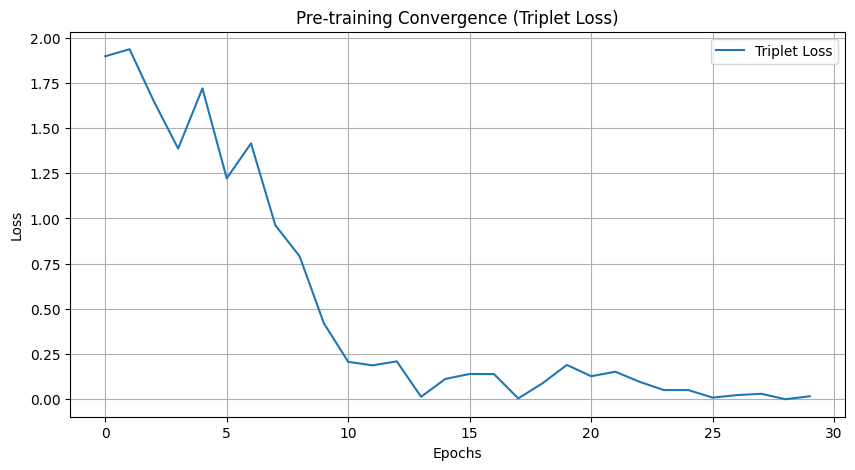

In [7]:
# Plot Training Loss
plt.figure(figsize=(10, 5))
plt.plot(history['loss'], label='Triplet Loss')
plt.title('Pre-training Convergence (Triplet Loss)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()